# Melbourne Housing Prediction - Team 4

---

### Mô tả: 

Tìm hiểu về dữ liệu và xây dựng mô hình dự đoán giá nhà ở Melbourne bằng mô hình hồi quy.

### Import các thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 1. Data validation

### Load data

In [2]:
train = pd.read_csv("DATA/train.csv", index_col='id')
test = pd.read_csv("DATA/test.csv", index_col='id')

In [3]:
train.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
id,,,,,,,,,,,,,,,,,,,,,
0,Pascoe Vale,1/22 Archibald St,3,t,900000.0,S,Nelson,12/08/2017,8.5,3044.0,...,2.0,1.0,0.0,149.0,2014.0,Moreland City Council,-37.72882,144.93301,Northern Metropolitan,7485.0
1,Northcote,3 Lorna Av,2,h,1800000.0,S,McGrath,18/03/2017,5.5,3070.0,...,NaN,NaN,NaN,NaN,NaN,Darebin City Council,NaN,NaN,Northern Metropolitan,11364.0
2,Aspendale,75 Laura St,3,h,988000.0,S,Biggin,23/09/2017,21.5,3195.0,...,NaN,NaN,NaN,NaN,NaN,Kingston City Council,NaN,NaN,South-Eastern Metropolitan,2824.0
3,Ormond,2 Stewart St,3,h,940000.0,PI,Buxton,16/07/2016,11.8,3204.0,...,1.0,1.0,397.0,124.0,1940.0,Glen Eira City Council,-37.90640,145.02910,Southern Metropolitan,3578.0
4,Coburg,171 The Avenue,3,h,1035000.0,S,Nelson,24/02/2018,6.7,3058.0,...,1.0,2.0,375.0,169.0,1930.0,Darebin City Council,-37.75339,144.97687,Northern Metropolitan,11204.0


In [ ]:
print(f'Kích thước tập train: {train.shape}')
print(f'Kích thước tập test: {test.shape}')

Kích thước tập train: (13623, 21)
Kích thước tập test: (13624, 20)


## 1.1. Thông tin tổng quan data

### Kiểm tra xem các hàng có trùng nhau không?

In [ ]:
duplicate_row = train[train.duplicated()]
print(duplicate_row)

Empty DataFrame
Columns: [Suburb, Address, Rooms, Type, Price, Method, SellerG, Date, Distance, Postcode, Bedroom2, Bathroom, Car, Landsize, BuildingArea, YearBuilt, CouncilArea, Lattitude, Longtitude, Regionname, Propertycount]
Index: []

[0 rows x 21 columns]


Không có hàng trùng trong tập Train.

### Tìm hiểu về các trường dữ liệu

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13623 entries, 0 to 13622
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13623 non-null  object 
 1   Address        13623 non-null  object 
 2   Rooms          13623 non-null  int64  
 3   Type           13623 non-null  object 
 4   Price          13623 non-null  float64
 5   Method         13623 non-null  object 
 6   SellerG        13623 non-null  object 
 7   Date           13623 non-null  object 
 8   Distance       13623 non-null  float64
 9   Postcode       13623 non-null  float64
 10  Bedroom2       10432 non-null  float64
 11  Bathroom       10428 non-null  float64
 12  Car            10243 non-null  float64
 13  Landsize       8962 non-null   float64
 14  BuildingArea   5267 non-null   float64
 15  YearBuilt      6004 non-null   float64
 16  CouncilArea    13623 non-null  object 
 17  Lattitude      10518 non-null  float64
 18  Longti

### Phân loại các cột dữ liệu

In [ ]:
train.dtypes.value_counts()

float64    12
object      8
int64       1
dtype: int64

### Quan sát các thống kê

In [ ]:
train.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13623.000000,1.362300e+04,13623.000000,13623.000000,10432.000000,10428.000000,10243.000000,8962.000000,5267.000000,6004.000000,10518.000000,10518.000000,13623.000000
mean,2.989870,1.047997e+06,11.215878,3113.720253,3.039973,1.593019,1.720394,611.196050,150.446832,1967.093105,-37.806937,144.997252,7517.737209
std,0.960175,6.355273e+05,6.731874,110.587317,0.953342,0.701201,1.001522,4970.010833,124.617794,35.855576,0.090033,0.119603,4451.998589
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1820.000000,-38.184150,144.423790,121.000000
25%,2.000000,6.370000e+05,6.400000,3046.000000,2.000000,1.000000,1.000000,215.000000,100.000000,1950.000000,-37.860700,144.926200,4280.000000
50%,3.000000,8.700000e+05,10.400000,3088.000000,3.000000,1.000000,2.000000,509.000000,132.000000,1970.000000,-37.800600,145.002970,6567.000000
75%,4.000000,1.285000e+06,14.000000,3153.000000,4.000000,2.000000,2.000000,666.000000,180.000000,2000.000000,-37.749100,145.068600,10331.000000
max,16.000000,8.000000e+06,48.100000,3978.000000,16.000000,8.000000,10.000000,433014.000000,6791.000000,2019.000000,-37.407200,145.523700,21650.000000


In [ ]:
test.describe()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13624.000000,13623.000000,13623.000000,10374.000000,10372.000000,10180.000000,9020.000000,5389.000000,6080.000000,10475.000000,10475.000000,13621.000000
mean,2.994715,11.344674,3113.871908,3.052535,1.590339,1.710314,575.895676,163.077729,1966.131250,-37.806989,144.996168,7615.832171
std,0.949415,6.842254,111.693311,0.956913,0.700589,0.986833,1897.920577,619.526827,37.633245,0.093189,0.121756,4532.044893
min,1.000000,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.190430,144.431810,83.000000
25%,2.000000,6.400000,3046.000000,2.000000,1.000000,1.000000,224.000000,101.000000,1948.000000,-37.861080,144.924000,4385.000000
50%,3.000000,10.500000,3088.000000,3.000000,1.000000,2.000000,516.000000,134.000000,1970.000000,-37.800300,145.003500,6567.000000
75%,4.000000,14.000000,3153.000000,4.000000,2.000000,2.000000,661.000000,184.000000,2000.000000,-37.748830,145.068900,10412.000000
max,12.000000,48.100000,3978.000000,20.000000,9.000000,18.000000,89030.000000,44515.000000,2018.000000,-37.397800,145.526350,21650.000000


In [ ]:
train.select_dtypes(exclude=[np.number]).describe()

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
count,13623,13623,13623,13623,13623,13623,13623,13623
unique,331,13513,3,5,285,78,33,8
top,Reservoir,14 James St,h,S,Nelson,28/10/2017,Boroondara City Council,Southern Metropolitan
freq,342,3,9191,8680,1381,422,1278,4267


In [ ]:
test.select_dtypes(exclude=[np.number]).describe()

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
count,13624,13624,13624,13624,13624,13624,13621,13621
unique,335,13494,3,5,289,78,33,8
top,Reservoir,13 George St,h,S,Nelson,28/10/2017,Boroondara City Council,Southern Metropolitan
freq,385,3,9281,8835,1354,457,1242,4257


**Nhận xét:**
- Có nhiều trường bị thiếu dữ liệu như `Bedroom2`, `Bathroom`, `Car`, `Landsize`, `BuildingArea`, `YearBuilt`, ...
- Các trường `Bedroom2`, `Bathroom`, `Car`, `Landsize` và `BuildingArea` có min là 0 có thể do lỗi trong thu thập dữ liệu.
- Thống kê các features của 2 tập `train` và `test` tương đối nhất quán, trừ trường `Landsize` và `BuildingArea` có sự khác nhau trong phân bố ở 2 tập do có các giá trị lớn (max của `Landsize` ở tập `train` và max của `BuildingArea` ở tập `test`).
- Phân bố của các hầu hết trường (trừ `Lattitude` và `Longtitude`) đều bị lệch.
- Trường `Type` và `Method` thực tế có ít loại hơn trong Data Description.
- Tập test có những loại không có tập Train như ở trường `Suburb`, `SellerG`.

In [ ]:
display(train[train.BuildingArea == 0].head(5))
display(train[train.BuildingArea == 0].shape)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
id,,,,,,,,,,,,,,,,,,,,,
37,Huntingdale,33 Beauford St,3,h,1205000.0,SA,FN,23/09/2017,12.3,3166.0,...,2.0,4.0,622.0,0.0,1960.0,Monash City Council,-37.90823,145.10851,Southern Metropolitan,768.0
653,Brunswick West,1/1 Duggan St,2,u,420500.0,SP,Pagan,18/11/2017,5.2,3055.0,...,1.0,1.0,5497.0,0.0,2011.0,Moreland City Council,-37.75820,144.94000,Northern Metropolitan,7082.0
1975,Kilsyth,17 Birkenhead Dr,3,h,803000.0,S,Max,26/08/2017,26.0,3137.0,...,1.0,2.0,862.0,0.0,1970.0,Maroondah City Council,-37.79902,145.32092,Eastern Metropolitan,4654.0
2855,Bundoora,22 Moreton Cr,3,h,814000.0,S,Barry,3/09/2017,12.1,3083.0,...,1.0,2.0,542.0,0.0,1970.0,Banyule City Council,-37.70861,145.05691,Northern Metropolitan,10175.0
3213,Werribee,21 Sinns Av,3,h,550000.0,S,Ray,7/10/2017,14.7,3030.0,...,2.0,2.0,580.0,0.0,1980.0,Wyndham City Council,-37.90136,144.66925,Western Metropolitan,16166.0


(33, 21)

### Xem xét dữ liệu thiếu

In [ ]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()       
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)       
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    return mis_val_table_ren_columns

missing_values_table(train)

,Missing Values,% of Total Values
BuildingArea,8356,61.3
YearBuilt,7619,55.9
Landsize,4661,34.2
Car,3380,24.8
Bathroom,3195,23.5
Bedroom2,3191,23.4
Lattitude,3105,22.8
Longtitude,3105,22.8


In [ ]:
missing_values_table(test)

,Missing Values,% of Total Values
BuildingArea,8235,60.4
YearBuilt,7544,55.4
Landsize,4604,33.8
Car,3444,25.3
Bathroom,3252,23.9
Bedroom2,3250,23.9
Lattitude,3149,23.1
Longtitude,3149,23.1
CouncilArea,3,0.0
Regionname,3,0.0


**Nhận xét:**
- Các 8 trường bị thiếu trên 23% dữ liệu, nguyên nhân có thể do quá trình thu thập từ nhiều nguồn khác nhau.

## 1.2. Thông tin tổng quan target

In [ ]:
train.Price.describe()

count    1.362300e+04
mean     1.047997e+06
std      6.355273e+05
min      8.500000e+04
25%      6.370000e+05
50%      8.700000e+05
75%      1.285000e+06
max      8.000000e+06
Name: Price, dtype: float64

### Phân bố trường target

<AxesSubplot:xlabel='Price', ylabel='Density'>

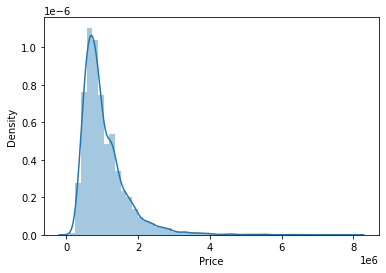

In [ ]:
sns.distplot(train['Price'])

# 2. Khai phá dữ liệu (EDA)

## 2.1 Phân tích target

In [ ]:
train.Price.describe()

count    1.362300e+04
mean     1.047997e+06
std      6.355273e+05
min      8.500000e+04
25%      6.370000e+05
50%      8.700000e+05
75%      1.285000e+06
max      8.000000e+06
Name: Price, dtype: float64

Skew is: 2.48700076136581


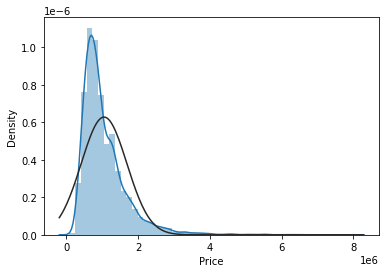

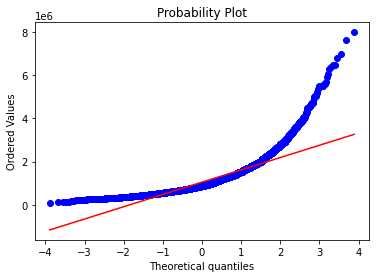

In [ ]:
sns.distplot(train['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
print ("Skew is:", train.Price.skew())

<AxesSubplot:xlabel='Price'>

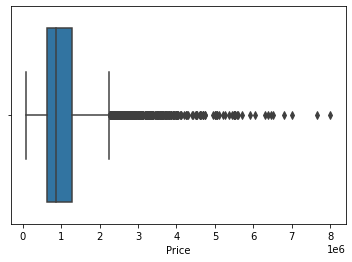

In [ ]:
sns.boxplot(train['Price'], orient='v' )

Từ 3 đồ thị trên:
- Biến giá nhà (Price) không theo phân phối chuẩn.
- Biến giá nhà bị lệch trái.
- Có nhiều khoảng giá trị bất thường (outlier).

### Sử dụng transform log(1+x) cho trường target

Skew is: 0.30791774999268184


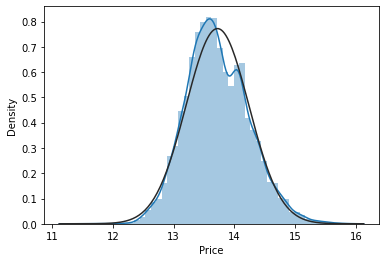

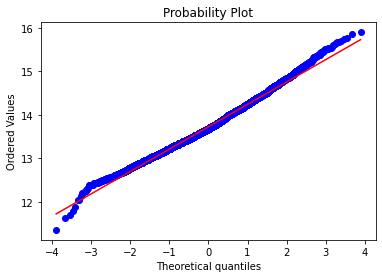

In [ ]:
sns.distplot(np.log1p(train['Price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log1p(train['Price']), plot=plt)
print ("Skew is:", np.log1p(train.Price).skew())

## 2.3. Phân tích dữ liệu phân loại (Categorical)

In [ ]:
def plot_feature(feature, axes):
    sns.boxplot(data=train.dropna(), x=feature, y='Price',ax=axes[0])
    axes[0].set_xlabel(feature)
    #axes[1,0].set_ylabel('Price')
    axes[0].set_title(f'{feature} v Price')
    sns.countplot(train[feature].dropna(), ax=axes[1])

Rút gọn tên của các vùng trong trường `Region` để dễ theo dõi hơn.

In [ ]:
train['Regionname'] = train['Regionname'].map({'Northern Metropolitan':'N Metro',
                                            'Western Metropolitan':'W Metro', 
                                            'Southern Metropolitan':'S Metro', 
                                            'Eastern Metropolitan':'E Metro', 
                                            'South-Eastern Metropolitan':'SE Metro', 
                                            'Northern Victoria':'N Vic',
                                            'Eastern Victoria':'E Vic',
                                            'Western Victoria':'W Vic'})

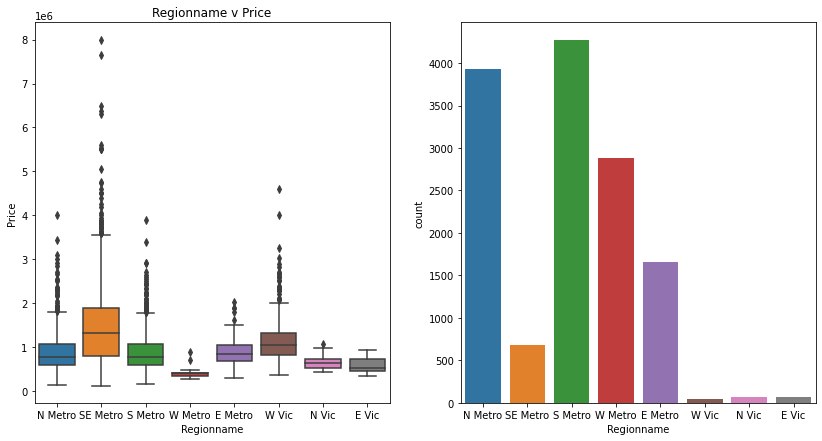

In [ ]:
feature = 'Regionname'
fig , axes = plt.subplots(1,2, figsize=(14,7), sharex=True)
plot_feature(feature, axes)

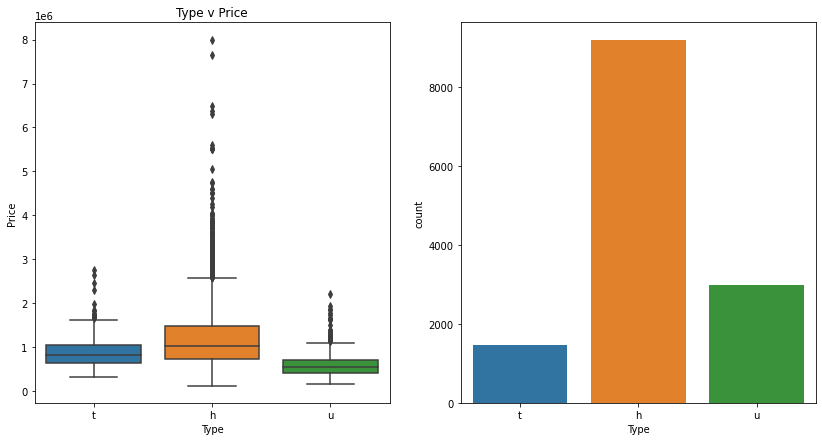

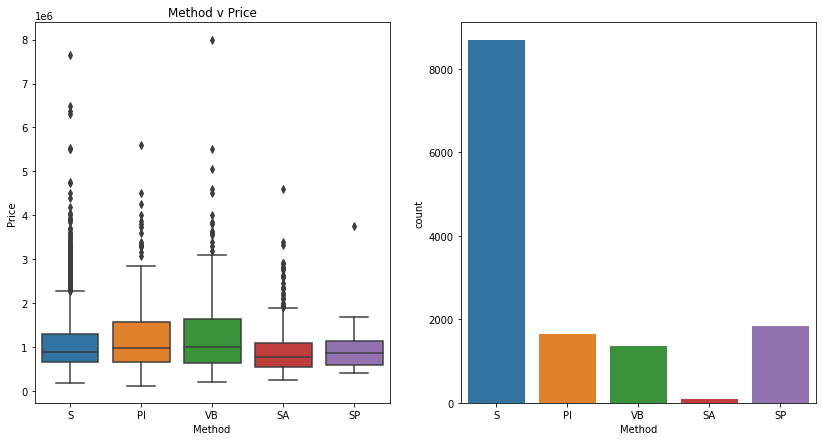

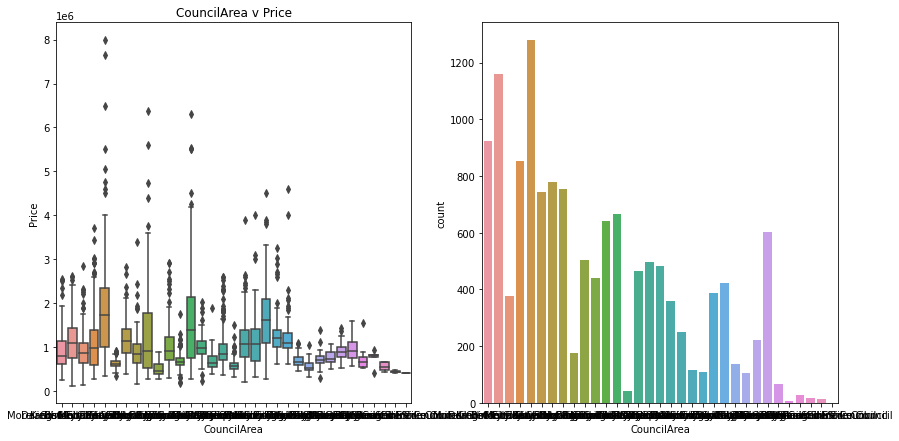

In [ ]:
for feature in ['Type', 'Method', 'CouncilArea']:
    fig , axes = plt.subplots(1,2, figsize=(14,7), sharex=True)
    plot_feature(feature, axes)

## 2.4. Phân tích dữ liệu số



### 2.4.1. Biến đổi trường `Date`

In [ ]:
ntrain = train.shape[0]
target = train.Price.values
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['Price'], axis=1, inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.drop('Date', axis='columns', inplace=True)

In [ ]:
df.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,...,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Day,Month,Year
0,Pascoe Vale,1/22 Archibald St,3,t,S,Nelson,8.5,3044.0,3.0,2.0,...,149.0,2014.0,Moreland City Council,-37.72882,144.93301,N Metro,7485.0,8,12,2017
1,Northcote,3 Lorna Av,2,h,S,McGrath,5.5,3070.0,NaN,NaN,...,NaN,NaN,Darebin City Council,NaN,NaN,N Metro,11364.0,18,3,2017
2,Aspendale,75 Laura St,3,h,S,Biggin,21.5,3195.0,NaN,NaN,...,NaN,NaN,Kingston City Council,NaN,NaN,SE Metro,2824.0,23,9,2017
3,Ormond,2 Stewart St,3,h,PI,Buxton,11.8,3204.0,3.0,1.0,...,124.0,1940.0,Glen Eira City Council,-37.90640,145.02910,S Metro,3578.0,16,7,2016
4,Coburg,171 The Avenue,3,h,S,Nelson,6.7,3058.0,3.0,1.0,...,169.0,1930.0,Darebin City Council,-37.75339,144.97687,N Metro,11204.0,24,2,2018


In [ ]:
train = df[:ntrain]
test = df[ntrain:]

### 2.4.2. Tổng quan dữ liệu

In [ ]:
numeric_features = train.select_dtypes(include=[np.number])

In [ ]:
numeric_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,13623.0,2.989870,0.960175,1.00000,2.0000,3.00000,4.0000,16.0000
Distance,13623.0,11.215878,6.731874,0.00000,6.4000,10.40000,14.0000,48.1000
Postcode,13623.0,3113.720253,110.587317,3000.00000,3046.0000,3088.00000,3153.0000,3978.0000
Bedroom2,10432.0,3.039973,0.953342,0.00000,2.0000,3.00000,4.0000,16.0000
Bathroom,10428.0,1.593019,0.701201,0.00000,1.0000,1.00000,2.0000,8.0000
Car,10243.0,1.720394,1.001522,0.00000,1.0000,2.00000,2.0000,10.0000
Landsize,8962.0,611.196050,4970.010833,0.00000,215.0000,509.00000,666.0000,433014.0000
BuildingArea,5267.0,150.446832,124.617794,0.00000,100.0000,132.00000,180.0000,6791.0000
YearBuilt,6004.0,1967.093105,35.855576,1820.00000,1950.0000,1970.00000,2000.0000,2019.0000
Lattitude,10518.0,-37.806937,0.090033,-38.18415,-37.8607,-37.80060,-37.7491,-37.4072


<AxesSubplot:>

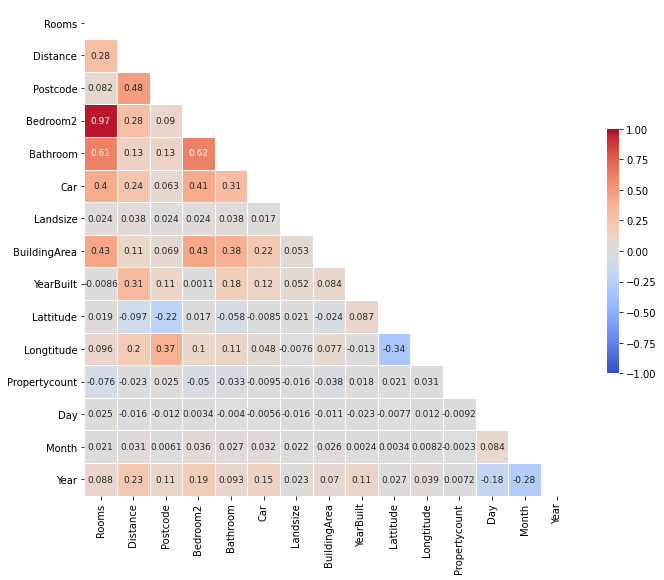

In [ ]:
corr = train.corr()  # Compute the correlation matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(12, 9))# Set up the matplotlib figure
sns.heatmap(corr, mask=mask, cmap='coolwarm',
            vmin = -1,vmax = 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot= True, annot_kws={"size": 9})# Draw the heatmap with the mask and correct aspect ratio

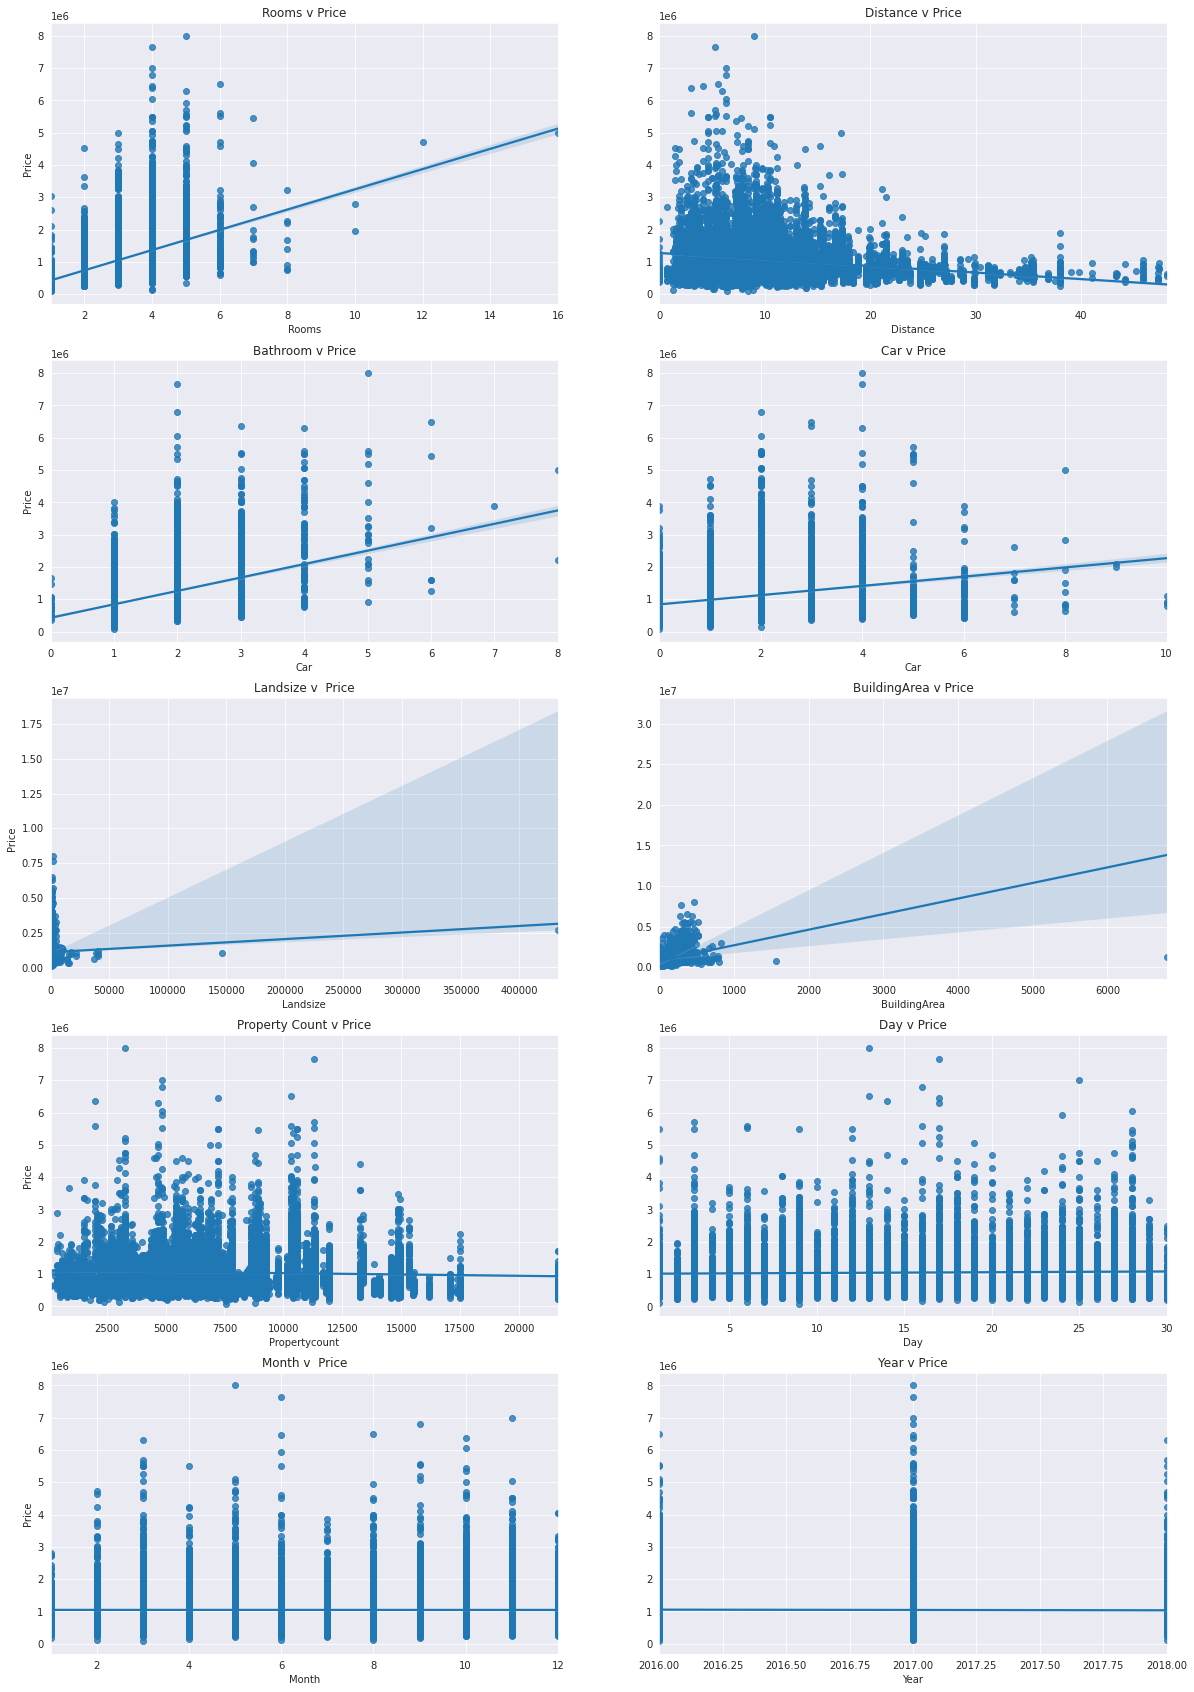

In [ ]:
# Suplots of numeric features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(5,2, figsize = (20,30))

# Plot [0,0]
sns.regplot(x = 'Rooms', y = target, data = train, ax=axes[0,0])
axes[0,0].set_xlabel('Rooms')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Rooms v Price')

# Plot [0,1]
sns.regplot(x = 'Distance', y = target, data = train, ax=axes[0,1])
axes[0,1].set_xlabel('Distance')
axes[0,1].set_title('Distance v Price')

# Plot [1,0]
sns.regplot(x = 'Bathroom', y = target, data = train, ax=axes[1,0])
axes[1,0].set_xlabel('Bathroom')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Bathroom v Price')

# Plot [1,1]
sns.regplot(x = 'Car', y = target, data = train, ax=axes[1,1])
axes[1,0].set_xlabel('Car')
axes[1,1].set_title('Car v Price')

# Plot [2,0]
sns.regplot(x = 'Landsize', y = target, data = train, ax=axes[2,0])
axes[2,0].set_xlabel('Landsize')
axes[2,0].set_ylabel('Price')
axes[2,0].set_title('Landsize v  Price')

# Plot [2,1]
sns.regplot(x = 'BuildingArea', y = target, data = train, ax=axes[2,1])
axes[2,1].set_xlabel('BuildingArea')
axes[2,1].set_title('BuildingArea v Price')

# Plot [3,0]
sns.regplot(x = 'Propertycount', y = target, data = train, ax=axes[3,0])
axes[3,0].set_xlabel('Propertycount')
axes[3,0].set_ylabel('Price')
axes[3,0].set_title('Property Count v Price')

# Plot [3,1]
sns.regplot(x = 'Day', y = target, data = train, ax=axes[3,1])
axes[3,1].set_xlabel('Day')
axes[3,1].set_title('Day v Price')

# Plot [4,0]
sns.regplot(x = 'Month', y = target, data = train, ax=axes[4,0])
axes[4,0].set_xlabel('Month')
axes[4,0].set_ylabel('Price')
axes[4,0].set_title('Month v  Price')

# Plot [4,1]
sns.regplot(x = 'Year', y = target, data = train, ax=axes[4,1])
axes[4,1].set_xlabel('Year')
axes[4,1].set_title('Year v Price')

plt.show()

# 3. Tiền xử lý dữ liệu



## 3.1. Data cleansing

In [ ]:
class DataFrameCleaner(TransformerMixin):
    
    def __init__(self):
        '''
        Fix errors in the process of collecting data:
        - "BuildingArea" = 0 -> median value
        - Create a 'Error' column to indicate if the value has been changed
        '''
        
    def fit(self, X, y=None):
        
        try:
            self.error = pd.Series([1 if c == 0 else 0 for c in X.BuildingArea], index=X.index)
            self.fixed = pd.Series([X.BuildingArea.median() if c == 0 else c for c in X.BuildingArea], index=X.index)
        except AttributeError:
            pass
        
        return self
    
    def transform(self, X, y=None):
        
        try:
            X.BuildingArea = self.fixed
            X['Error'] = self.error
        except AttributeError:
            pass
        
        return X

## 3.2. Xử lý dữ liệu thiếu

In [ ]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        - Create '{column_name}+_nan' columns to indicate if the value is imputed
        """
        self.fill_median = ['BuildingArea', 'Landsize', 'YearBuilt']
        self.fill_min = ['Car', 'Bedroom2', 'Bathroom', 'Rooms']
        self.fill_freq = ['CouncilArea', 'Regionname', 'Propertycount', 'Distance', 'Postcode', 'Lattitude', 'Longtitude']
        
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if c in self.fill_freq else X[c].median()
            if c in self.fill_median else X[c].min() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        
        for c in X:
            if c in self.fill_median + self.fill_min + self.fill_freq:
                X[c+'_nan'] = X[c].isnull()*1
                
        return X.fillna(self.fill)

# 4. Thiết lập Baseline

In [ ]:
train.columns.values

array(['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'Day', 'Month',
       'Year'], dtype=object)

### Label Encoding các trường phân loại

In [ ]:
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')

### Feature Selector và Baseline Model

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

In [ ]:
baseline_features = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount','Day', 'Month',
       'Year']

In [ ]:
baseline_preprocessor = Pipeline([
    ('selector', FeatureSelector(baseline_features)),
    ('cleaner', DataFrameCleaner()),
    ('imputer', DataFrameImputer()),
    ('encoder', encoder),
])

baseline_model = Pipeline([
    ('preprocessor', baseline_preprocessor),
    ('estimator', XGBRegressor())
])

In [ ]:
def score_dataset(X, y, model=baseline_model):

    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [ ]:
score_dataset(train, target)

0.2294181699583292

# 5. Feature Engineering

In [ ]:
def encode_address(c):
    try:
        if 'Avenue' in c or 'Av' in c:
            return 'Av'
    except TypeError:
        print(c)
    if 'St' in c:
        return 'St'
    if 'Rd' in c:
        return 'Rd'
    if 'Pde' in c:
        return 'Pde'
    if 'Pl' in c:
        return 'Pl'
    if 'Esplanade' in c or 'Esp' in c:
        return 'Esp'
    s = c.split()[-1]
    if s == 'Outlook':
        return 'Out'
    if s == 'Loop':
        return 'Lp'
    if s == 'Nook':
        return 'Nk'
    if s == 'Circuit':
        return 'Cct'
    if s == 'Terrace':
        return 'Tce'
    if s in ['Grove', 'Gve']:
        return 'Gr'
    if s == 'Greenway':
        return 'Gwy'
    if s in['Avenue', 'Aveue', 'Ave']:
        return 'Av'
    if s == 'Boulevard':
        return 'Bvd'
    if s in ['Street', 'street']:
        return 'St'
    if s == 'Crescent': # Crossway
        return 'Cr'
    if s == 'Wy':
        return 'Wky'
    if s == 'Highway':
        return 'Hwy'
    if s in ['Ridge', 'Ri', 'Ridgeway']:
        return 'Rdg'
    if s == 'Esplanade':
        return 'Esp'
    if s == 'Mews':
        return 'Mw'
    if s == 'Grange':
        return 'Gra'
    if s == 'Views':
        return 'Vw'
    if s == 'Parkway':
        return 'Pky'
    if s == 'Glade':
        return 'Gld'
    if 'The' in c:
        return 'The'
    return s

def to_season(month):
    if month in range(1, 4):
        return 'Spring'
    if month in range(4, 7):
        return 'Summer'
    if month in range(7, 10):
        return 'Fall'
    if month in range(10, 13):
        return 'Winter'

In [ ]:
class FeatureTransformer(TransformerMixin):
    
    def __init__(self):
        '''
        Feature Transformer:
        - Encode 'Address' using the fuction 'encode_address' above.
        - Encode 'Month' using the fuction 'to_season' above.
        '''
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Address'] = np.vectorize(encode_address)(X['Address'])
        # X['Season'] = np.vectorize(to_season)(X.Month)
        X['Age'] = np.where(2019 - X.YearBuilt > 50, "Historic", "Contemporary")
        return X
        

In [ ]:
features = ['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'Day', 'Month',
       'Year']

In [ ]:
preprocessor = Pipeline([
    ('selector', FeatureSelector(features)),
    ('cleaner', DataFrameCleaner()),
    ('imputer', DataFrameImputer()),
    ('transformer', FeatureTransformer()),
    ('encoder', encoder),
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBRegressor())
])

score_dataset(train, target, model=model)

0.22800576544618578

## 6. Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    tuning_model = Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', xgb),
    ])
    return score_dataset(train, target, model=tuning_model)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)
# xgb_params = study.best_params

[I 2021-08-25 18:31:58,497] A new study created in memory with name: no-name-553947b5-275a-4de8-a02e-e6d8084ded15
[I 2021-08-25 18:36:58,086] Trial 0 finished with value: 0.23224889004033755 and parameters: {'max_depth': 8, 'learning_rate': 0.0023021252688712195, 'n_estimators': 4575, 'min_child_weight': 4, 'colsample_bytree': 0.4029083509867222, 'subsample': 0.9304580000768503, 'reg_alpha': 0.1970274665750554, 'reg_lambda': 4.179128985626096}. Best is trial 0 with value: 0.23224889004033755.
[I 2021-08-25 18:38:19,571] Trial 1 finished with value: 0.23739339263476172 and parameters: {'max_depth': 2, 'learning_rate': 0.02005949547226834, 'n_estimators': 2173, 'min_child_weight': 10, 'colsample_bytree': 0.4965699648343058, 'subsample': 0.780208188301579, 'reg_alpha': 0.1351178543061148, 'reg_lambda': 0.8604687782651413}. Best is trial 0 with value: 0.23224889004033755.
[I 2021-08-25 18:41:45,985] Trial 2 finished with value: 0.2217813063583054 and parameters: {'max_depth': 3, 'learning_

In [ ]:
xgb_params = {
    'max_depth': 8, 
    'learning_rate': 0.04804510345985137, 
    'n_estimators': 1067, 
    'min_child_weight': 7, 
    'colsample_bytree': 0.243721007657978, 
    'subsample': 0.72095739604202, 
    'reg_alpha': 0.026338688165939338, 
    'reg_lambda': 8.312149146542485
}

In [ ]:
tuned_model = Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', XGBRegressor(**xgb_params)),
    ])

In [ ]:
tuned_model.fit(train, np.log(target))
predictions = np.exp(tuned_model.predict(test))

output = pd.DataFrame({'id': test.index, 'Price': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
output

,id,Price
0,13623,7.831146e+05
1,13624,1.005065e+06
2,13625,8.662637e+05
3,13626,6.384529e+05
4,13627,1.048861e+06
...,...,...
13619,27242,1.065221e+06
13620,27243,1.867297e+06
13621,27244,2.996709e+05
13622,27245,5.670162e+05
